In [1]:
%run radiomorpho.py

In [2]:
dirs  = ('101first_fit', '101nvss_fit')
files = get_file_list(dirs[1], 'fit')
# images = [readNormalizedImg(im) for im in files]
images = []
for im in files:
    try:
        img = readNormalizedImg(im)
        images.append(img)
    except:
        pass

In [3]:
def img_distance(im1, im2):
    dif = im1 - im2
    return np.linalg.norm(dif)

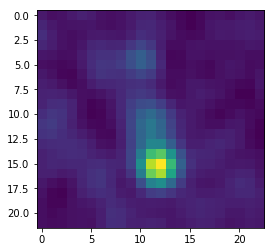

In [4]:
plt.imshow(images[2])

In [5]:
from skimage.transform import rotate, rescale

In [6]:
def best_rotate(im1, im2):
    min_dist = img_distance(im1, im2)
    angle = 0
    for i in range(1, 360):
        im_r = rotate(im2, i)
        ndist = img_distance(im1, im_r)
        if(ndist < min_dist):
            min_dist = ndist
            angle = i
    return angle

In [7]:
def min_size(images):
    min_sz = images[0].shape[0]
    for i in range(1, len(images)):
        if min_sz > images[i].shape[0]: min_size = images[i].shape[0]
    return min_sz

def reshape_images(images, sz):
    return [rescale(im, (sz/im.shape[0], sz/im.shape[1])) for im in images]

In [8]:
def min_size(images):
    min_sz = images[0].shape[0]
    for i in range(1, len(images)):
        if min_sz > images[i].shape[0]: min_size = images[i].shape[0]
    return min_sz

In [9]:
sz = min_size(images)
images_r = reshape_images(images, sz)

/home/jperalta/miniconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [10]:
best_rotate(images_r[0], images_r[1])

310

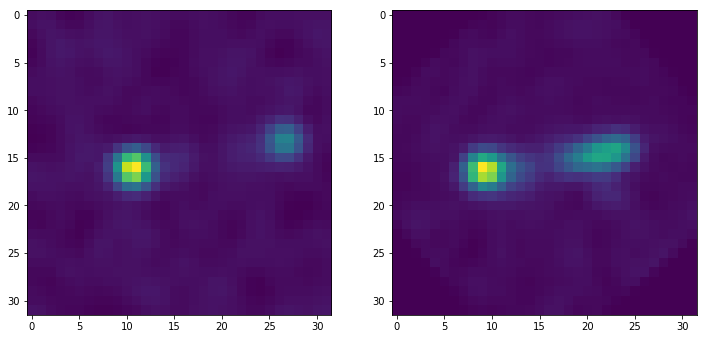

In [11]:
f, ax = plt.subplots(1, 2, figsize=(12,15))
ax[0].imshow(images_r[0])
ax[1].imshow(rotate(images_r[1],310))

In [12]:
%time
def procrates_dist(images_r, n_iter = 5):
    avg_img = images_r[0]
    new_avg = np.zeros_like(avg_img)
    for it in range(n_iter):
        for i in range(len(images_r)):
            angle = best_rotate(avg_img, images_r[i])
            images_r[i] = rotate(images_r[i], angle)
            new_avg += images_r[i] / len(images_r)
        avg_img = new_avg
    return images_r, avg_img

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 5.25 µs


In [13]:
%time
images_r, avg_img = procrates_dist(images_r)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.15 µs


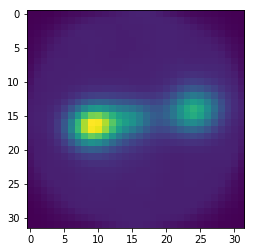

In [14]:
plt.imshow(avg_img)

In [15]:
dt = [img.reshape(1, 32*32) [0] for img in images_r]
from sklearn import decomposition
pca = decomposition.PCA(n_components=2)
pca.fit(dt)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

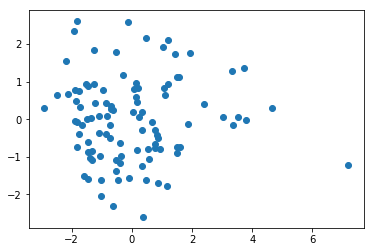

In [16]:
Y = pca.transform(dt)
xs, ys = Y[:,0] , Y[:,1]
plt.scatter(xs, ys)

<IPython.core.display.Javascript object>


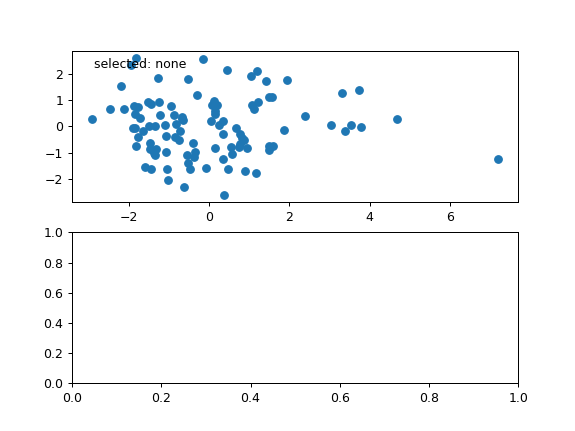

In [17]:
%matplotlib notebook
class DataBrowser(object):
    """
    Click on a point to select and highlight it -- the data that
    generated the point will be shown in the lower axes.  Use the 'n'
    and 'p' keys to browse through the next and previous points
    """

    def __init__(self, fig, ax1, ax2, xs, ys):
        self.lastind = 0

        self.text = ax1.text(0.05, 0.95, 'selected: none',
                            transform=ax1.transAxes, va='top')
        self.selected, = ax1.plot([xs[0]], [ys[0]], 'o', ms=12, alpha=0.4,
                                 color='yellow', visible=False)
        self.xs = xs
        self.ys = ys
        self.fit = fig

        self.ax2 = ax2

    def onpress(self, event):
        if self.lastind is None:
            return
        if event.key not in ('n', 'p'):
            return
        if event.key == 'n':
            inc = 1
        else:
            inc = -1

        self.lastind += inc
        self.lastind = np.clip(self.lastind, 0, len(self.xs) - 1)
        self.update()

    def onpick(self, event):

        if event.artist != line:
            return True

        N = len(event.ind)
        if not N:
            return True

        # the click locations
        x = event.mouseevent.xdata
        y = event.mouseevent.ydata

        distances = np.hypot(x - self.xs[event.ind], y - self.ys[event.ind])
        indmin = distances.argmin()
        dataind = event.ind[indmin]

        self.lastind = dataind
        self.update()

    def update(self):
        if self.lastind is None:
            return

        dataind = self.lastind

        img = images_r[dataind]
        self.ax2.cla()
        self.ax2.imshow(img, cmap='gray')

        self.selected.set_visible(True)
        self.selected.set_data(self.xs[dataind], self.ys[dataind])

#         self.text.set_text('selected: {}'.format(
#             '.'.join(files[dataind].split('/')[1].split('.')[:-2])))
        self.fig.canvas.draw()

fig, (ax, ax2) = plt.subplots(2, 1)
line, = ax.plot(xs, ys, 'o', picker=5)
browser = DataBrowser(fig, ax, ax2, xs, ys)
fig.canvas.mpl_connect('pick_event', browser.onpick)
fig.canvas.mpl_connect('key_press_event', browser.onpress)
plt.show()